# Árboles de decisión

Crearemos un arbol de decisión para predecil el salario `log(Salary)` de un jugador de béisbol, basado en el numero de años que lleva jugando en las grandes ligas `Years`, y el numero de batazos de hit `Hits` que hizo en el año anterior.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Leemos los datos:

In [5]:
hitters = pd.read_csv('../data/hitters.csv').dropna()
hitters['LogSalary'] = np.log(hitters.Salary)
hitters = hitters[['Years', 'Hits', 'LogSalary']]
hitters.head()

,Years,Hits,LogSalary
1,14,81,6.163315
2,3,130,6.173786
3,11,141,6.214608
4,2,87,4.516339
5,11,169,6.620073


### Recursive Binary Splitting
1.- Select the predictor $X_j$ and the cut point $s$ such that splitting the predictor space into regions $R_1(j,s) = \{X|X_j < s\}$ and $R_2 =(j,s) = \{X|X_j \geqslant s\}$ that leads to the greatest posible reduction in RSS.

$$\sum_{i: x_i\in R_1(j,s)} (y_i - \hat y_{R_1})^2 + \sum_{i: x_i\in R_2(j,s)} (y_i - \hat y_{R_2})^2 $$

In [9]:
# Un árbol esta definido por la siguiente estructura
# {'left': None, 'right': None, 'df': df, 'rss': 0}

def _residual_squared_sum(df, y):
    """
    Calculate the residual squared sum in R, using the target y.
    """
    yhat = df[y].mean()
    rss = ((df[y] - yhat)**2).sum()
    return rss, yhat

_residual_squared_sum(hitters, 'LogSalary')

(207.15373313638489, 5.9272215412213924)

2.- We repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire predictor space, we split one of the two previously identified regions. We now have three regions. Again, we look to split one of these three regions further, so as to minimize the RSS. The process continues until a stopping criterion is reached; for instance, we may continue until no region contains more than five observations.

In [56]:
def _binary_splitting(df, y, x_j):
    """
    Find the best split using the predictor x_j. 
    """
    cut_values = sorted(set(df[x_j]))
    min_s = None
    min_rss, _ = _residual_squared_sum(df, y)
    for i in range(len(cut_values) - 1):
        s = (cut_values[i] + cut_values[i+1]) / 2
    
        left_rss, _ = _residual_squared_sum(df[df[x_j] < s ] , y)
        right_rss, _ = _residual_squared_sum(df[df[x_j] >= s] , y)
        rss = left_rss + right_rss
        
        if rss < min_rss:
            min_s = s
            min_rss = rss
    
    split = {
        'rss': min_rss,
        's': min_s,
        'x_j': x_j,
        'left_df': df[df[x_j] < min_s ],
        'right_df': df[df[x_j] >= min_s]
    }
    return split

#_binary_splitting(hitters, 'LogSalary', 'Years')

In [58]:
def _recursive_binary_splitting(df, y, predictors):
    """
    Select the best variable to reduce the
    residual square sum from predictors.
    """
    assert(len(predictors) > 0) # You should have at least one predictor
    min_split = _binary_splitting(df, y, predictors[0])
    min_rss = min_split['rss']
    for x_j in predictors[1:]:
        split = _binary_splitting(df, y, x_j)
        if split['rss'] < min_rss:
            min_split = split
            min_rss = split['rss']
     
    return {
        'rss': min_rss,
        's': min_split['s'],
        'x_j': min_split['x_j'],
        'left_df': min_split['left_df'],
        'right_df': min_split['right_df']
    }
#_recursive_binary_splitting(hitters, 'LogSalary', ['Years', 'Hits'])

In [76]:
def _make_tree(df, y):
    rss, yhat = _residual_squared_sum(df, y)
    return {'left': None, 'right':None, 
            'rss': rss,
            'yhat': yhat,
            'df': df,
            'y': y}

def _grow_tree(tree, predictors, min_points_per_leaf=5):
    """
    Recursively divide tree using the split that
    minimize rss. It stops when the region have
    less than 5 elements.
    """
    if len(tree['df']) <= min_points_per_leaf:
        return tree
    
    split = _recursive_binary_splitting(tree['df'], tree['y'], predictors)
    left_tree = _make_tree(split['left_df'], tree['y'])
    right_tree = _make_tree(split['right_df'], tree['y'])

    _grow_tree(left_tree, predictors, min_points_per_leaf=min_points_per_leaf)
    _grow_tree(right_tree, predictors, min_points_per_leaf=min_points_per_leaf)
    
    tree['left'] = left_tree
    tree['right'] = right_tree
    tree['x_j'] = split['x_j']
    tree['s'] = split['s']
    
    return tree

hitters_tree = _make_tree(hitters, 'LogSalary')
_grow_tree(hitters_tree, ['Years', 'Hits'], min_points_per_leaf=100)

{'df':      Years  Hits  LogSalary
 1       14    81   6.163315
 2        3   130   6.173786
 3       11   141   6.214608
 4        2    87   4.516339
 5       11   169   6.620073
 6        2    37   4.248495
 7        3    73   4.605170
 8        2    81   4.317488
 9       13    92   7.003065
 10      10   159   6.248319
 11       9    53   6.239301
 12       4   113   6.309918
 13       6    60   6.551080
 14      13    43   5.480639
 16      15   158   6.652863
 17       5    46   5.164786
 19       8    32   4.905275
 20       1    92   4.605170
 21       1   109   4.744932
 23       6   116   6.396930
 24      18   168   6.655012
 25       6   163   6.639876
 26       7    73   6.562914
 27      10   129   6.620073
 28       5   152   6.437752
 29      14   137   6.802395
 31       3   108   4.700480
 33       5   168   6.417549
 34       7    49   5.703782
 35      14   106   6.745236
 ..     ...   ...        ...
 287      4   213   5.857933
 288      8   103   5.788941
 289    

3.- Once the regions $R_1,...,R_J$ have been created,we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.

In [84]:
def _evaluate(tree, event):
    if tree['left'] == None and tree['right'] == None:
        return tree['yhat']
    if event[tree['x_j']] < tree['s']:
        return _evaluate(tree['left'], event)
    else:
        return _evaluate(tree['right'], event)

_evaluate(hitters_tree, hitters.iloc[0])

5.9983798474087635

In [85]:
hitters.iloc[0]

Years        14.000000
Hits         81.000000
LogSalary     6.163315
Name: 1, dtype: float64

## Tree Pruning
Cost complexity:

For each value of $\alpha$ there corresponds a subtree $T \subset T_0$ such that

$$\sum_{m=1}^T \sum_{i: x_i \in R_m} (y_i - \hat y_{R_m})^2 + \alpha |T|$$

is as small as possible. $|T|$ indicates the number of terminal nodes of the tree $T$, $R_m$ is the rectangle (i.e. the subset of predictor space) corresponding to the $m$th terminal node, and $\hat y_{R_m}$ is the predicted response associated with $R_m$. 


1.- Calculate the total rss of a tree.

In [ ]:
def _is_leaf(tree):
    """
    Return if a given tree is a leaf.
    """
    return True

def _tree_rss(tree):
    """
    Calculate the total rss of a tree: the sum of the rss of
    all leaves.
    """
    rss = 0
    return rss

_tree_rss(hitters_tree)

2.- Count the number of leaves in the tree.

In [ ]:
def _count_leafs(tree):
    """
    Return the number of leaves in the tree.
    """
    leafs = 0
    return leafs

_count_leafs(hitters_tree)

3.- Calculate the cost complexity of the tree.

4.- Find the banch that if removed increase the tree rss the least.

In [ ]:
def _is_last_branch(tree):
    """
    Return if a given tree is the last branch, i.e. both 
    subtrees are leaves.
    """
    return True

def _find_min_deltarss(tree):
    """
    Find the tree that reduces for which the split reduces
    the least the rss.
    """
    min_deltarss = 0
    min_tree = tree
    return min_deltarss, min_tree

_find_min_deltarss(hitters_tree)

5.- Remove one by one the `min_deltarss` branch until the tree is a single leaf, while calculating the cost complexity. Return the tree that minimizes the cost complexity.

In [ ]:
from copy import deepcopy

def _prune_tree(tree, alpha):
    min_cc_tree = deepcopy(tree)
    return min_cc_tree

_prune_tree(hitters_tree, 0.1)

# Visualización

In [86]:
import graphviz
from IPython import display

def make_node(g, name, tree):
    attributes = {'label': 'rss: {:0.2f}'.format(tree['rss']),
                  'shape': 'square'}
    if tree.get('yhat'):
        attributes['label'] += '\n yhat: {:0.2f}'.format(tree['yhat'])
    g.node(name, **attributes)
    
def make_edge(g, parent, child, tree, direction):
    attributes = {}
    if direction == 'l':
        attributes['label'] = '{} < {}'.format(tree['x_j'], tree['s'])
    if direction == 'r':
        attributes['label'] = '{} >= {}'.format(tree['x_j'], tree['s'])
    g.edge(parent, child, **attributes)
    

def construct_tree(g, dna, tree):
    if not tree['left'] and not tree['right']:
        make_node(g, dna, tree)
    else:
        make_node(g, dna + 'l', tree['left'])
        make_edge(g, dna, dna + 'l', tree, 'l')
        construct_tree(g, dna + 'l', tree['left'])

        make_node(g, dna + 'r', tree['right'])
        make_edge(g, dna, dna + 'r', tree, 'r')
        construct_tree(g, dna + 'r', tree['right'])
        
def visualize_tree(tree):
    g = graphviz.Graph('tree', 'tree.dot', engine='dot')
    make_node(g, 'r', tree)
    construct_tree(g, 'r', tree)
    display.display(g)


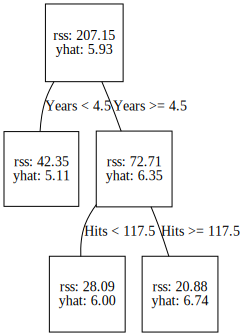

In [87]:
visualize_tree(hitters_tree)